In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from scipy.linalg import expm, eig, logm
from qiskit import QuantumCircuit, QuantumRegister, BasicAer, execute
from operators.pauli_hamiltonian import PauliHamiltonian
from quantum_circuit.trotterization import trotter_electric, trotter_coupling
import matplotlib.pyplot as plt
from functools import reduce
from utils.matrix_operations import *

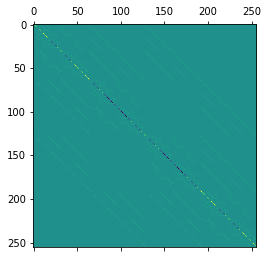

In [175]:
# Nsites-site XY with cutoff L = M/2 with PBCs
T = 2.
g = 1.
L = 1
M = 2*L
Nsites = 4
coefList = []
pauliList = []
# electric terms
for i in range(Nsites): # site
    for j in range(M): # flavor 1
        for k in range(j+1, M): # flavor 2
            coefList.append(1.0)
            pauliList.append({i*M+j: "Z", i*M+k: "Z"})

# potential terms
for i in range(Nsites): # site
    for j in range(M): # flavor of i-th site
        for k in range(M): # flavor of (i+1) site
            coefList.append(g**2/2.)
            coefList.append(g**2/2.)
            pauliList.append({i*M+j: "+", ((i+1)%Nsites)*M+k: "-"})
            pauliList.append({i*M+j: "-", ((i+1)%Nsites)*M+k: "+"})
H = PauliHamiltonian(coefList, pauliList, n_sites=Nsites*M)
#exact = expm(-1j*H.matrix_form()*T)
#spectrum, _ = eig(exact)
plt.matshow(H.matrix_form().real)
#print(exact)
#print(spectrum)
evals, evecs= np.linalg.eigh(H.matrix_form())
#exact_evol = [expm(-1j*H.matrix_form()*T*(stp+1)/100) for stp in range(100)]

In [102]:
evals[:10]

array([-5.97981926, -5.12310563, -5.12310563, -4.89218588, -4.89218588,
       -4.89218588, -4.89218588, -4.44948974, -4.44948974, -4.44948974])

In [85]:
# Initialize Simulator
backend = BasicAer.get_backend('unitary_simulator')

# XY model trotter circuit

In [234]:
trot_evol_xy = []
trot2_evol_xy = []
trot4_evol_xy = []
exact_evol_xy = []
T = 4.0
n_steps =40
# Construct Circuit
qr = QuantumRegister(Nsites*M, 'qr')
circ = QuantumCircuit(qr)
circ2 = QuantumCircuit(qr)
circ4 = QuantumCircuit(qr)
for stp in range(n_steps):
    # measure <0|U|0> for each Trotter step
    
    # electric terms
    for i in range(Nsites): # site
        for j in range(M): # flavor 1
            for k in range(j+1, M): # flavor 2
                trotter_electric(circ, [i*M+j, i*M+k], 1.0, T/n_steps, unitary_sim = True, further_opt = False)
                
    # potential terms
    for i in range(Nsites): # site
        for j in range(M): # flavor of i-th site
            for k in range(M): # flavor of (i+1) site
                trotter_coupling(circ, [i*M+j, ((i+1)%Nsites)*M+k], g**2/2., T/n_steps, further_opt = False)
                
    job = execute(circ, backend)
    #eigvals, _ = eig(job.result().get_unitary(circ, decimals=3))
    trot_evol_xy.append(job.result().get_unitary(circ, decimals=6))
    
    
    # larger t/n
    if stp%2 == 0: 
        # electric terms
        for i in range(Nsites): # site
            for j in range(M): # flavor 1
                for k in range(j+1, M): # flavor 2
                    trotter_electric(circ2, [i*M+j, i*M+k], 1.0, T*2/n_steps, unitary_sim = True, further_opt = False)
                
        # potential terms
        for i in range(Nsites): # site
            for j in range(M): # flavor of i-th site
                for k in range(M): # flavor of (i+1) site
                    trotter_coupling(circ2, [i*M+j, ((i+1)%Nsites)*M+k], g**2/2., T*2/n_steps, further_opt = False)
                    
        job = execute(circ2, backend)
        #eigvals, _ = eig(job.result().get_unitary(circ, decimals=3))
        trot2_evol_xy.append(job.result().get_unitary(circ2, decimals=6))
        
    # larger t/n
    if stp%4 == 0: 
        # electric terms
        for i in range(Nsites): # site
            for j in range(M): # flavor 1
                for k in range(j+1, M): # flavor 2
                    trotter_electric(circ4, [i*M+j, i*M+k], 1.0, T*4/n_steps, unitary_sim = True, further_opt = False)
                
        # potential terms
        for i in range(Nsites): # site
            for j in range(M): # flavor of i-th site
                for k in range(M): # flavor of (i+1) site
                    trotter_coupling(circ4, [i*M+j, ((i+1)%Nsites)*M+k], g**2/2., T*4/n_steps, further_opt = False)
        job = execute(circ4, backend)
        #eigvals, _ = eig(job.result().get_unitary(circ, decimals=3))
        trot4_evol_xy.append(job.result().get_unitary(circ4, decimals=6))
    
    #exact_evol.append(expm(-1j*H.matrix_form()*T*(stp+1)/n_steps))
exact_evol_xy = [expm(-1j*H.matrix_form()*T*(stp+1)/100) for stp in range(100)]

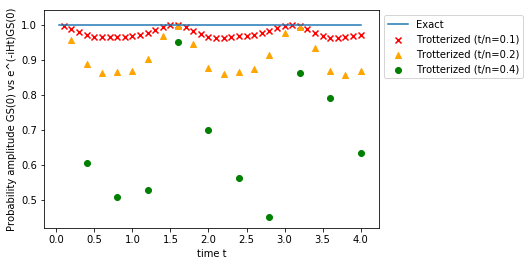

In [213]:
evals, evecs= np.linalg.eigh(H.matrix_form())
targ_vec = np.reshape(evecs[:, 0], [-1, 1])
plt.scatter(np.arange(1, n_steps+1)*(T/n_steps), [abs(reduce(np.matmul, [np.conjugate(targ_vec).T, trot_evol_xy[i], targ_vec]))[0, 0]**2 for i in range(n_steps)], label='Trotterized (t/n=0.1)', marker="x", color='red')
plt.scatter((np.arange(n_steps//2)+1)*(T*2/n_steps), [abs(reduce(np.matmul, [np.conjugate(targ_vec).T, trot2_evol_xy[i], targ_vec]))[0, 0]**2 for i in range(n_steps//2)], label='Trotterized (t/n=0.2)', marker="^", color='orange')
plt.scatter((np.arange(n_steps//4)+1)*(T*4/n_steps), [abs(reduce(np.matmul, [np.conjugate(targ_vec).T, trot4_evol_xy[i], targ_vec]))[0, 0]**2 for i in range(n_steps//4)], label='Trotterized (t/n=0.4)', marker="o", color='green')
plt.plot(np.arange(1, 100+1)*(T/100), [abs(reduce(np.matmul, [np.conjugate(targ_vec).T, exact_evol_xy[i], targ_vec]))[0, 0]**2 for i in range(100)], label='Exact')

plt.xlabel("time t")
plt.ylabel("Probability amplitude GS(0) vs e^(-iHt)GS(0)")
plt.legend(bbox_to_anchor=(1., 1))
plt.show()

In [152]:
obs_Z0 = tensor_prod([np.array([[1, 0], [0, -1]]) if i == Nsites*M-1 else np.eye(2) for i in range(Nsites*M)])
obs_Z1 = tensor_prod([np.array([[1, 0], [0, -1]]) if i == Nsites*M-2 else np.eye(2) for i in range(Nsites*M)])

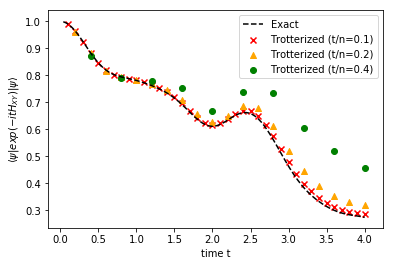

In [235]:
targ_vec = np.zeros(2**(Nsites*M))
targ_vec[3] = 1.
plt.scatter(np.arange(1, n_steps+1)*(T/n_steps), [abs(matmul([np.conjugate(targ_vec).T, trot_evol_xy[i], targ_vec])) for i in range(n_steps)], label='Trotterized (t/n=0.1)', marker="x", color='red')
plt.scatter((np.arange(n_steps//2)+1)*(T*2/n_steps), [abs(matmul([np.conjugate(targ_vec).T, trot2_evol_xy[i], targ_vec])) for i in range(n_steps//2)], label='Trotterized (t/n=0.2)', marker="^", color='orange')
plt.scatter((np.arange(n_steps//4)+1)*(T*4/n_steps), [abs(matmul([np.conjugate(targ_vec).T, trot4_evol_xy[i], targ_vec])) for i in range(n_steps//4)], label='Trotterized (t/n=0.4)', marker="o", color='green')
plt.plot(np.arange(1, 100+1)*(T/100), [abs(matmul([np.conjugate(targ_vec).T, exact_evol_xy[i], targ_vec])) for i in range(100)], label='Exact', linestyle='--', color='k')
#plt.plot(np.arange(1, n_steps+1)*(T/n_steps), [abs(matmul([np.conjugate(targ_vec).T, exact_evol_xy[i], targ_vec])) for i in range(n_steps)], label='Exact')

plt.xlabel("time t")
plt.ylabel(r"$ \langle \psi |exp(-itH_{XY})|\psi \rangle $")
plt.legend(bbox_to_anchor=(1., 1))
plt.show()

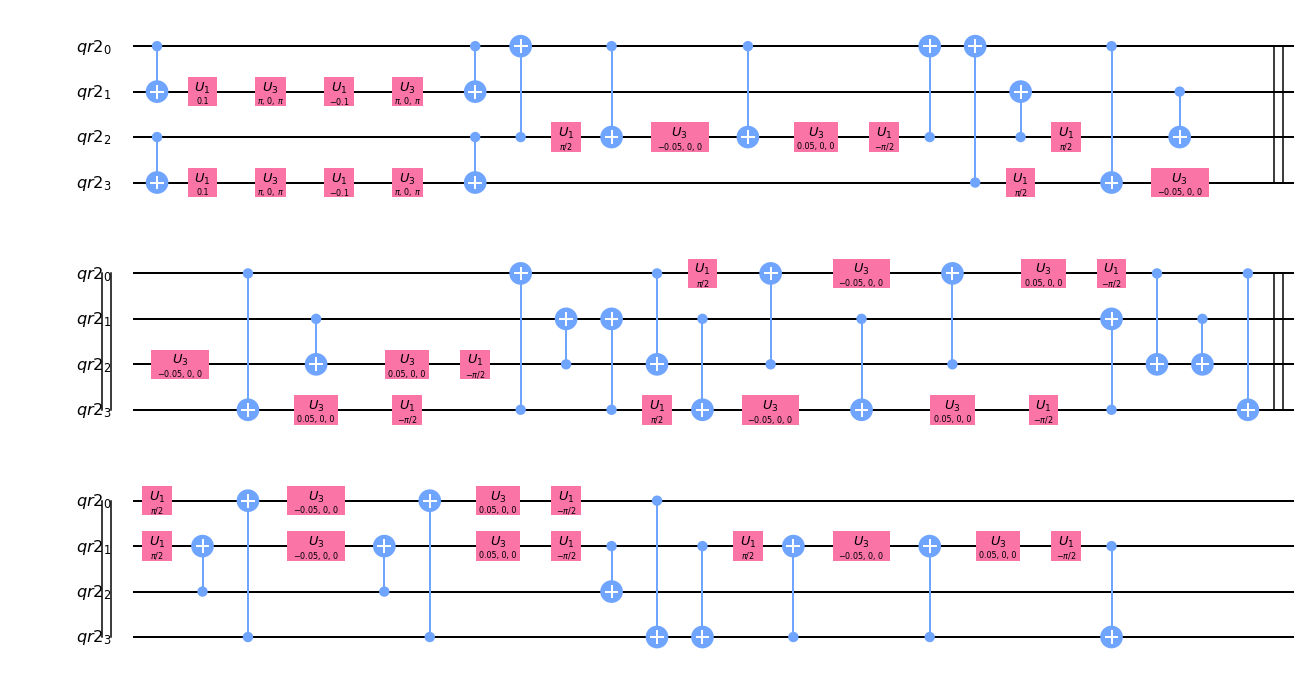

In [218]:
qr2 = QuantumRegister(4, 'qr2')
circ_draw = QuantumCircuit(qr2)
# electric terms
for i in range(2): # site
    for j in range(M): # flavor 1
        for k in range(j+1, M): # flavor 2
            trotter_electric(circ_draw, [i*M+j, i*M+k], 1.0, T/n_steps, unitary_sim = False, further_opt = False)
                
# potential terms
for i in range(2): # site
    for j in range(M): # flavor of i-th site
        for k in range(M): # flavor of (i+1) site
            trotter_coupling(circ_draw, [i*M+j, ((i+1)%2)*M+k], g**2/2., T/n_steps, further_opt = False)
            
circ_draw.draw(output='mpl')

# SG model trotterization

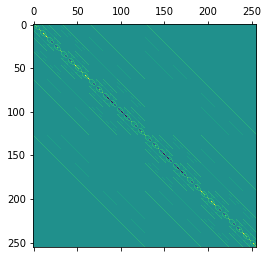

In [89]:
# Nsites-site SG with cutoff L = M/2 with PBCs
g = 1.0
h = 1.0
L = 1
M = 2*L
Nsites = 4
coefList = []
pauliList = []
# electric terms
for i in range(Nsites): # site
    for j in range(M): # flavor 1
        for k in range(j+1, M): # flavor 2
            coefList.append(1.0)
            pauliList.append({i*M+j: "Z", i*M+k: "Z"})

# potential terms
#for i in range(Nsites): # site
for i in range(Nsites-1):
    for j in range(M): # flavor of i-th site
        for k in range(M): # flavor of (i+1) site
            coefList.append(g**2/2.)
            coefList.append(g**2/2.)
            pauliList.append({i*M+j: "+", ((i+1)%Nsites)*M+k: "-"})
            pauliList.append({i*M+j: "-", ((i+1)%Nsites)*M+k: "+"})
            
# self interaction (or should be called as the transverse field?)
for i in range(Nsites): 
    for j in range(M): # flavor of i-th site
        coefList.append(h)
        pauliList.append({i*M+j: "X"})
        
HSG = PauliHamiltonian(coefList, pauliList, n_sites=Nsites*M)
#exact = expm(-1j*H.matrix_form()*T)
#spectrum, _ = eig(exact)
plt.matshow(HSG.matrix_form().real)
#print(exact)
#print(spectrum)

In [93]:
# Kink solution
T = 10.
targ_vec = np.zeros(2**(Nsites*M))
targ_vec[3] = 1.
kink_evol = np.array([abs(np.matmul(expm(-1j*HSG.matrix_form()*T*(stp+1)/100), targ_vec))**2 for stp in range(100)])

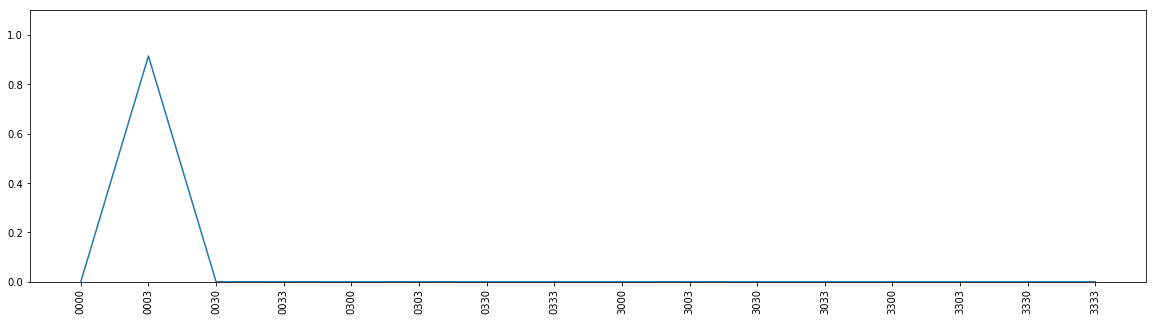

In [94]:
from matplotlib.animation import FuncAnimation

def base_change(n, base, n_digits):
    num_str = ''
    for i in range(n_digits)[::-1]:
        num_str += str(n//(base**i))
        n -= (n//(base**i))*(base**i)
    return num_str

fig, ax = plt.subplots(figsize=(20,5))
xdata, ydata = [], []
#target_idx = range(2**(Nsites*M))
target_idx = np.array([0, 3, 12, 15, 48, 51, 60, 63, 192, 195, 204, 207, 240, 243, 252, 255])
xlist = [base_change(i, 4, 4) for i in target_idx]
ln, = ax.plot(xlist, kink_evol[0][target_idx])
plt.xticks(rotation = 90)

def init():
    ax.set_ylim(0, 1.1)
    return ln,

def update(frame):
    xdata.append(xlist)
    ydata.append(kink_evol[frame][target_idx])
    ln.set_data(xlist, kink_evol[frame][target_idx])
    return ln,

ani = FuncAnimation(fig, update, frames=100,
                    init_func=init, blit=True)

In [95]:
from IPython.display import HTML
HTML(ani.to_jshtml())

In [232]:
trot_evol_sg = []
trot2_evol_sg = []
trot4_evol_sg = []
exact_evol_sg = []
T = 4.0
n_steps = 40
in_state = np.zeros(2**(Nsites*M))
in_state[0] = 1.0
# Construct Circuit
qr = QuantumRegister(Nsites*M, 'qr')
circ = QuantumCircuit(qr)
circ2 = QuantumCircuit(qr)
circ4 = QuantumCircuit(qr)
for stp in range(n_steps):
    # measure <0|U|0> for each Trotter step
    
    # electric terms
    for i in range(Nsites): # site
        for j in range(M): # flavor 1
            for k in range(j+1, M): # flavor 2
                trotter_electric(circ, [i*M+j, i*M+k], 1.0, T/n_steps, unitary_sim = True, further_opt = False)
                
    # potential terms
    for i in range(Nsites): # site
        for j in range(M): # flavor of i-th site
            for k in range(M): # flavor of (i+1) site
                trotter_coupling(circ, [i*M+j, ((i+1)%Nsites)*M+k], g**2/2., T/n_steps, further_opt = False)
                
    # self interaction (or should be called as the transverse field?)
    for i in range(Nsites): 
        for j in range(M): # flavor of i-th site
            circ.rx(2*h* T/n_steps, qr[i*M+j])

    job = execute(circ, backend)
    #eigvals, _ = eig(job.result().get_unitary(circ, decimals=3))
    trot_evol_sg.append(job.result().get_unitary(circ, decimals=6))
    
    # larger t/n
    if stp%2== 0: 
        # electric terms
        for i in range(Nsites): # site
            for j in range(M): # flavor 1
                for k in range(j+1, M): # flavor 2
                    trotter_electric(circ2, [i*M+j, i*M+k], 1.0, T*2/n_steps, unitary_sim = True, further_opt = False)
                
        # potential terms
        for i in range(Nsites): # site
            for j in range(M): # flavor of i-th site
                for k in range(M): # flavor of (i+1) site
                    trotter_coupling(circ2, [i*M+j, ((i+1)%Nsites)*M+k], g**2/2., T*2/n_steps, further_opt = False)
        
        # self interaction (or should be called as the transverse field?)
        for i in range(Nsites): 
            for j in range(M): # flavor of i-th site
                circ2.rx(2*h* T*2/n_steps, qr[i*M+j])
            
        job = execute(circ2, backend)
        #eigvals, _ = eig(job.result().get_unitary(circ, decimals=3))
        trot2_evol_sg.append(job.result().get_unitary(circ2, decimals=6))
    
    # larger t/n
    if stp%4 == 0: 
        # electric terms
        for i in range(Nsites): # site
            for j in range(M): # flavor 1
                for k in range(j+1, M): # flavor 2
                    trotter_electric(circ4, [i*M+j, i*M+k], 1.0, T*4/n_steps, unitary_sim = True, further_opt = False)
                
        # potential terms
        for i in range(Nsites): # site
            for j in range(M): # flavor of i-th site
                for k in range(M): # flavor of (i+1) site
                    trotter_coupling(circ4, [i*M+j, ((i+1)%Nsites)*M+k], g**2/2., T*4/n_steps, further_opt = False)
        
        # self interaction (or should be called as the transverse field?)
        for i in range(Nsites): 
            for j in range(M): # flavor of i-th site
                circ4.rx(2*h* T*4/n_steps, qr[i*M+j])
            
        job = execute(circ4, backend)
        #eigvals, _ = eig(job.result().get_unitary(circ, decimals=3))
        trot4_evol_sg.append(job.result().get_unitary(circ4, decimals=6))
    
    #exact_evol.append(expm(-1j*HSG.matrix_form()*T*(stp+1)/n_steps))
exact_evol_sg = [expm(-1j*HSG.matrix_form()*T*(stp+1)/100) for stp in range(100)]

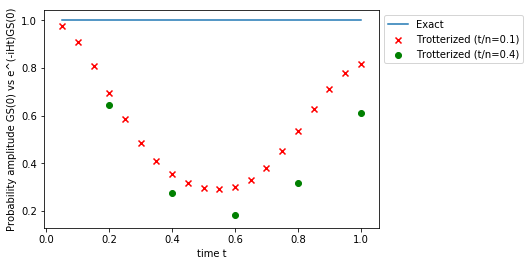

In [47]:
evals, evecs= np.linalg.eigh(HSG.matrix_form())
targ_vec = np.reshape(evecs[:, 0], [-1, 1])
plt.scatter(np.arange(1, n_steps+1)*(T/n_steps), [abs(reduce(np.matmul, [np.conjugate(targ_vec).T, trot_evol[i], targ_vec]))[0, 0]**2 for i in range(n_steps)], label='Trotterized (t/n=0.1)', marker="x", color='red')
plt.scatter((np.arange(n_steps//4)+1)*(T*4/n_steps), [abs(reduce(np.matmul, [np.conjugate(targ_vec).T, trot4_evol[i], targ_vec]))[0, 0]**2 for i in range(n_steps//4)], label='Trotterized (t/n=0.4)', marker="o", color='green')
plt.plot(np.arange(1, n_steps+1)*(T/n_steps), [abs(reduce(np.matmul, [np.conjugate(targ_vec).T, exact_evol[i], targ_vec]))[0, 0]**2 for i in range(n_steps)], label='Exact')

plt.xlabel("time t")
plt.ylabel("Probability amplitude GS(0) vs e^(-iHt)GS(0)")
plt.legend(bbox_to_anchor=(1., 1))
plt.show()

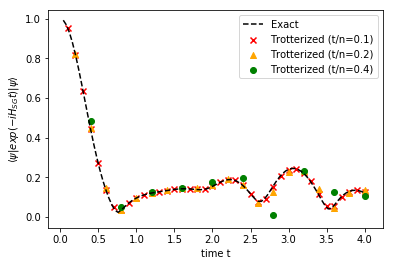

In [236]:
targ_vec = np.zeros(2**(Nsites*M))
targ_vec[3] = 1.
plt.scatter(np.arange(1, n_steps+1)*(T/n_steps), [abs(matmul([np.conjugate(targ_vec).T, trot_evol_sg[i], targ_vec])) for i in range(n_steps)], label='Trotterized (t/n=0.1)', marker="x", color='red')
plt.scatter((np.arange(n_steps//2)+1)*(T*2/n_steps), [abs(matmul([np.conjugate(targ_vec).T, trot2_evol_sg[i], targ_vec])) for i in range(n_steps//2)], label='Trotterized (t/n=0.2)', marker="^", color='orange')
plt.scatter((np.arange(n_steps//4)+1)*(T*4/n_steps), [abs(matmul([np.conjugate(targ_vec).T, trot4_evol_sg[i], targ_vec])) for i in range(n_steps//4)], label='Trotterized (t/n=0.4)', marker="o", color='green')
plt.plot(np.arange(1, 100+1)*(T/100), [abs(matmul([np.conjugate(targ_vec).T, exact_evol_sg[i], targ_vec])) for i in range(100)], label='Exact', linestyle='--', color='k')
#plt.plot(np.arange(1, n_steps+1)*(T/n_steps), [abs(matmul([np.conjugate(targ_vec).T, exact_evol[i], targ_vec])) for i in range(n_steps)], label='Exact')

plt.xlabel("time t")
plt.ylabel(r"$ \langle \psi |exp(-iH_{SG}t)|\psi \rangle $")
plt.legend(bbox_to_anchor=(1., 1))
plt.show()